## MLP 모델 설계 순서

1. 필요한 모듈 import.
2. 딥러닝 모델 활용 장비 확인.
3. MNIST 데이터 다운로드하기 & Train, Test 분리하기.
4. 데이터 확인하기. (1)
5. 데이터 확인하기. (2)
6. MLP 모델 설계하기.
7. Optimizer, Objective Function 설정하기.
8. 학습을 진행하면서 Train 데이터에 대한 모델 성능을 확인하는 함수 정의하기.
9. 학습을 진행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인하기.

In [12]:
''' 1. Module Import '''
import numpy as np # (1)
import matplotlib.pyplot as plt # (2)
import torch # (3)
import torch.nn as nn # (4)
import torch.nn.functional as F # (5)
from torchvision import transforms, datasets # (6)

1. 선형 대수 관련 함수 모듈.
2. 함수 실행 결과 산출물에 대한 수치 시각화.
3. 파이토치의 기본 모듈.
4. 파이토치 모듈 중 딥러닝 (인공 신경망 설계) 을 설계할 때 필요한 함수를 모아놓은 모듈.
5. torch.nn 모듈 중에서도 자주 이용되는 함수를 F로 지정.
6. 컴퓨터 비전 연구 분야에서 자주 이용하는 'torchvision' 모듈 내 'transforms', 'datasets' 함수.

In [13]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.10.0+cpu  Device: cpu


In [14]:
batch_size = 32 # (1)
epochs = 10 # (2)

1. batch_size : 학습할 때 필요한 데이터 개수의 단위.
    - mini-batch 1개 단위에 대해 데이터가 32개로 구성.
    - Iteration : 1개의 미니배치를 이용해 학습하는 횟수.
    - Epoch : 전체 데이터를 이용해 학습을 진행한 횟수. 하이퍼파라미터.
        - ex) 전체 데이터 1만개, 미니배치 1000개 -> 1epoch당 10회의 iteration이 발생.
        
2. epochs : 존재하고 있는 mini-batch를 전부 이용하는 횟수. 하이퍼파라미터.

In [15]:
''' 3. MNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.MNIST(root = '../data/MNIST',          # (1)
                              train = True,
                              download = True,
                              transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = '../data/MNIST',          # (2)
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, # (3)
                                          batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,   # (4)
                                         batch_size = batch_size,
                                         shuffle = False)

1. MNIST 데이터셋을 다운로드.
2. MNIST 데이터셋을 다운로드.
    - root : 데이터가 저장될 장소를 지정. (상위 디렉터리에 존재하는 data폴더 내 MNIST 폴더에 저장)
    - train : True는 train_dataset으로 설정. False는 test_dataset으로 설정.
    - download : 해당 데이터를 인터넷상에서 다운로드해 이용할 것인지.
    - transform : MNIST는 이미지. 기본적인 전처리를 진행할 것인지. tensor 형태로 변경.
        - 한 픽셀은 0 ~ 255 범위의 스칼라 값으로 구성. 이를 0 ~ 1 범위로 정규화.
        - MLP 모델이 포함된 모델은 Input 데이터 값의 크기가 커질수록 과적합 or 불안정.
            - 정규화 과정을 이용해 Input으로 이용하는 것이 좋음.
            
3. 다운로드한 데이터셋을 mini-batch 단위로 분리해 지정.
4. 다운로드한 데이터셋을 mini-batch 단위로 분리해 지정.
    - mini-batch 별로 데이터를 묶어 단위를 맞춤.
    - 이미지 데이터를 batch size만큼 묶어 1개의 mini-batch를 구성.
    - dataset : mini-batch 단위로 할당하고자 하는 데이터셋 지정.
    - batch_size : mini-batch 1개 단위를 구성하는 데이터의 개수 지정.
    - shuffle : 데이터의 순서를 섞고자 할 때 이용.
        - 이미지 데이터의 특징을 학습하는 것이 아닌 Label 값을 학습하는 것을 방지하기 위함.

In [16]:
''' 4. 데이터 확인하기 (1) '''
for (x_train, y_train) in train_loader:
    print('x_train:', x_train.size(), 'type:', x_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


- x_train : 32개의 이미지가 1개의 mini-batch로 구성. 가로 28, 세로 28개의 픽셀로 구성. 채널은 1 (grayscale).
- y_train : 32개의 이미지 데이터 각각에 label값이 1개씩 존재. (32개의 값을 가지고 있음)

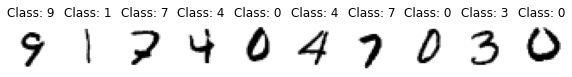

In [17]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28 ,28), cmap = 'gray_r')
    plt.title('Class: ' + str(y_train[i].item()))

## 일반 MLP

In [18]:
''' 6. MLP (Multi Layer Perceptron) 모델 설계하기 '''

class Net(nn.Module):                      # (1)
    
    def __init__(self):                    # (2)
        super(Net, self).__init__()        # (3)
        self.fc1 = nn.Linear(28 * 28, 512) # (4)
        self.fc2 = nn.Linear(512, 256)     # (5)
        self.fc3 = nn.Linear(256, 10)      # (6)
        
    def forward(self, x):                  # (7)
        x = x.view(-1, 28 * 28)            # (8)
        x = self.fc1(x)                    # (9)
        x = F.sigmoid(x)                   # (10)
        x = self.fc2(x)                    # (11)
        x = F.sigmoid(x)                   # (12)
        x = self.fc3(x)                    # (13)
        x = F.log_softmax(x, dim = 1)      # (14)
        
return x                                   # (15)

1. nn.Module 클래스를 상속받는 Net 클래스를 정의.
2. Net 클래스의 instance를 생성했을 때, 지니게 되는 성질을 정의.
3. nn.Module 내의 메서드를 상속.
4. 첫 번째 Fully Connected Layer를 정의.
    - Fully Connected Layer : feed forward neural networks.
    - 마지막 몇 개의 계층을 형성.
    - Fully Connected Layer의 대한 input은 final Pooling 이나 Convolutional Layer.
    - Pooling 이나 Convolution이 평면화되어 입력됨.
        - MNIST 데이터를 Input으로 사용하기 위해 28, 28, 1 (가로, 세로, 채널) 크기의 노드 수를 Input으로 설정.
        - 그 후 두 번째 FC Layer의 노드 수를 512개로 설정할 것이기 때문에 output의 노드 수는 512개로 설정.
5. 두 번째 Fully Connected Layer를 정의.
    - Input은 512 크기의 벡터 값을 사용하기 위해 512, 세 번째 FC Layer의 노드 수가 256개이기 때문에 Output은 256개.
6. 세 번째 Fully Connected Layer를 정의.
    - Input은 256 크기의 벡터 값을 사용하기 위해 256, output으로 사용하기 위한 노드 수를 10개로 설정.
        - 0 ~ 9까지 10개의 클래스를 표현하기 위한 Label 값은 One-hot Encoding으로 표현.
        - MLP 모델의 Output 값과 Loss를 계산하려면 이에 맞는 크기의 벡터를 계산해야 함. 따라서 Output의 노드 수를 10개로 정의.
7. Net 클래스를 이용해 MLP 모델의 Forward Propagation을 정의.
    - 즉, 설계한 MLP 모델에 데이터를 입력했을 때 Output을 계산하기까지의 과정을 나열.
8. MNIST 이미지 데이터는 크기가 28 * 28인 2차원 데이터. MLP 모델은 1차원의 벡터 값을 입력으로 받아야 함.
    - 이를 위해 View 메서드를 이용해 784 크기의 1차원 데이터로 변환. (Flatten)
9. __init__() 메서드를 이용해 첫 번째 Fully Connected Layer에 1차원으로 펼친 이미지 데이터를 통과.
10. torch.nn.functional 내 정의된 비선형 함수인 sigmoid()를 이용. 두 번째 FC Layer의 Input으로 계산.
11. __init__() 메서드를 이용해 두 번째 Fully Connected Layer에 (10)에서 sigmoid() 함수를 이용해 계산된 결과값을 통과.
12. torch.nn.functional 내 정의된 비선형 함수인 sigmoid()를 이용. 세 번째 FC Layer의 Input으로 계산.
13. __init__() 메서드를 이용해 세 번째 Fully Connected Layer에 (11)에서 sigmoid() 함수를 이용해 계산된 결과값을 통과.
14. torch.nn.functional 내 정의된 비선형 함수인 log.softmax()를 이용. 최종 output을 계산.
    - 10가지 경우의 수 중 하나로 분류하는 일을 수행하기 때문에 softmax를 이용해 확률 값을 계산.
    - log_softmax를 사용하는 이유 : 역전파 알고리즘을 사용시, Loss 값에 대한 Gradient 값을 좀 더 원활하게 계산할 수 있음.
        - Log 함수 그래프의 기울기는 부드럽게 변화.
15. 최종 계산된 x값을 output으로 반환.

## MLP + Dropout

In [ ]:
''' 6. MLP (Multi Layer Perceptron) 모델 설계하기 '''

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        
return x

- Dropout을 적용했을 때 일반화가 강해져 Test Accuracy가 높아지는 결과가 기대.
    - 학습과 검증 데이터셋의 feature, 레이블의 분포 간 많은 차이가 있을 때 유효하게 작용.
    - MNIST는 학습과 검증 데이터셋 간 많은 차이가 발생하지 않기 때문에 성능이 조금 하락할 수도 있음.
        - Epoch을 늘려 추가로 학습을 진행하면 성능이 좋아짐.
- Dropout은 보통 ReLU() 비선형 함수와 잘 어울림.

## Dropout + ReLU

In [ ]:
''' 6. MLP (Multi Layer Perceptron) 모델 설계하기 '''

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        
return x

- ReLU() 함수
    - 0미만인 값은 0으로 계산, 양수 값은 그대로 반영.
    - Gradient를 빠르게 계산, Back Propagation을 효과적으로 이용.
- Sigmoid() 함수
    - 0에서 멀어질 수록 Gradient 값이 0에 가까워 Back Propagation을 효과적으로 이용할 수 없음.

## Dropout + ReLU + Batch Normalization

In [ ]:
''' 6. MLP (Multi Layer Perceptron) 모델 설계하기 '''

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512) # (1)
        self.batch_norm2 = nn.BatchNorm1d(256) # (2)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x) # (3)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x) # (4)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        
return x

1. nn.BatchNorm()을 Class 내에서 이용하기 위해 self.batch_norm1 으로 정의. 512차원으로 설정.
    - 첫 번째 Fully Connected Layer의 Output이 512 크기의 벡터 값이기 때문.
2. nn.BatchNorm()을 Class 내에서 이용하기 위해 self.batch_norm2 으로 정의. 256차원으로 설정.
    - 두 번째 Fully Connected Layer의 Output이 256크기의 벡터 값이기 때문.
3. 첫 번째 Fully Connected Layer의 Output을 위에서 정의한 self.batch_norm1의 Input으로 이용.
4. 두 번째 Fully Connected Layer의 Output을 위에서 정의한 self.batch_norm2의 Input으로 이용.

## SGD

In [20]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = Net().to(device)                                                   # (!)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5) # (2)
criterion = nn.CrossEntropyLoss()                                          # (3)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


1. 위에서 정의한 MLP 모델을 기존에 선정한 device에 할당.
2. Back Propagation을 이용해 파라미터를 업데이트할 때 이용하는 Optimizer를 정의. (SGD, eta=0.01, momentum=0.5)
3. MLP 모델의 output과 계산될 Label 값은 Class를 표현하는 One-hot encoding 값.
    - MLP 모델의 output값, One-hot encoding 값과의 loss는 CrossEntropy를 이용해 계산하기 위해
    - criterion = 'nn.CrossEntropyLoss' 로 설정.

## Dropout + ReLU + Batch Normalization + He Uniform Initialization

In [ ]:
''' 7. Optimizer, Objective Function 설정하기 '''
import torch.nn.init as init                # (1)
def weight_init(m):                          # (2)
    if isinstance(m, nn.Linear):             # (3)
        init.kaiming_uniform_(m.weight.data) # (4)

model = Net().to(device)
model.apply(weight_init)                     # (5)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

1. init모듈 : 초깃값으로 설정되는 요소에 대한 모듈 (weight, bias 등)
2. MLP 모델 내의 Weight를 초기화할 부분을 설정하기 위해 weight_init함수를 정의.
3. MLP 모델을 구성하고 있는 파라미터 중 nn.Linear에 해당하는 파라미터 값에 대해서만 지정.
4. nn.Linear에 해당하는 파라미터 값에 대해 he_initialization을 이용해 파라미터 값을 초기화.
5. weight_init 함수를 Net() 클래스의 인스턴스인 model에 적용.

## Dropout + ReLU + Batch Normalization + He Uniform Initialization + Adam

In [ ]:
''' 7. Optimizer, Objective Function 설정하기 '''
import torch.nn.init as init                # (1)
def weight_init(m):                          # (2)
    if isinstance(m, nn.Linear):             # (3)
        init.kaiming_uniform_(m.weight.data) # (4)

model = Net().to(device)
model.apply(weight_init)                     # (5)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [23]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()                                                # (1)
    for batch_idx, (image, label) in enumerate (train_loader):  # (2)
        image = image.to(device)                                 # (3)
        label = label.to(device)                                 # (4)
        optimizer.zero_grad()                                    # (5)
        output = model(image)                                    # (6)
        loss = criterion(output, label)                          # (7)
        loss.backward()                                          # (8)
        optimizer.step()                                         # (9)
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(Epoch, batch_idx * len(image),
                                                                                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                                                                                loss.item()))

1. 위에서 정의한 MLP 모델을 학습 상태로 지정.
2. train_loader : 이미지 데이터, 레이블 데이터가 mini-batch 단위로 묶여 저장.
    - 이를 순서대로 이용해 MLP 모형을 학습.
3. 이미지 데이터를 기존 정의된 장비에 할당.
4. 레이블 데이터를 기존 정의된 장비에 할당.
5. 과거에 이용한 mini-batch 내의 이미지, 레이블 데이터를 바탕으로 계산된 loss의 gradient 값이 optimizer에 할당.
    - optimizer의 gradient를 초기화.
6. 이미지 데이터를 MLP 모델의 input으로 이용해 output을 계산.
7. Output, 레이블 데이터를 CrossEntropy를 이용해 Loss를 계산.
8. Loss를 계산한 결과를 바탕으로 Back Propagation을 통해 계산된 Gradient를 각 파라미터에 할당. (weight, bias)
9. gradient 값을 이용해 파라미터 값을 업데이트.

In [24]:
'''9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의'''
def evaluate(model, test_loader):
    model.eval()                                                              # (1)
    test_loss = 0                                                             # (2)
    correct = 0                                                               # (3)
    
    with torch.no_grad():                                                     # (4)
        for image, label in test_loader:                                      # (5)
            image = image.to(device)                                          # (6)
            label = label.to(device)                                          # (7)
            output = model(image)                                             # (8)
            test_loss += criterion(output, label).item()                      # (9)
            prediction = output.max(1, keepdim = True)[1]                    # (10)
            correct += prediction.eq(label.view_as(prediction)).sum().item()  # (11)
            
    test_loss /= len(test_loader.dataset)                                     # (12)
    test_accuracy = 100. * correct / len(test_loader.dataset)                 # (13)
    return test_loss, test_accuracy                                           # (14)

### 학습 과정, 학습 완료 상태에서 성능을 평가하기 위한 evaluation 함수를 정의.
1. MLP 모델을 학습 상태 -> 평가 상태로 지정.
2. test_loader 내의 데이터를 이용해 Loss 값을 계산하기 위해 test_loss를 0으로 임시 설정.
3. 모델이 올바른 Class로 분류한 경우를 세기 위해 correct를 0으로 임시 설정.
4. 평가 단계에서 Gradient를 통해 업데이트되는 현상을 방지하기 위해 torch.no_grad() 메서드를 이용해 흐름을 억제.
5. test_loader 데이터도 mini-batch 단위로 저장되어 있음. mini-batch 내에 있는 이미지, 레이블 데이터를 차례대로 접근.
6. 이미지 데이터로 모델을 검증하기 위해 기존에 정의한 장비에 할당.
7. 레이블 데이터를 기존에 정의한 장비에 할당.
8. 이미지 데이터를 Input으로 Output을 계산.
9. output과 레이블 데이터를 CrossEntropy를 이용해 Loss값을 계산한 결과값을 'test_loss'에 더해 업데이트.
10. MLP 모델의 Output값은 크기가 10인 벡터 값. 
    - 계산된 벡터값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단.
11. MLP 모델이 최종으로 예측한 클래스 값과 실제 레이블이 의미하는 클래스가 맞으면 correct에 더해 올바른 예측 횟수를 저장.
12. 현재까지 계산된 test_loss 값 = test_loader 내의 mini-batch 개수만큼 나눠 평균 loss 값으로 계산.
13. test_loader 데이터 중 얼마나 맞췄는지 정확도를 계산.
14. test_loss, test_accuracy를 반환.

In [25]:
'''10. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy를 확인하기'''
for Epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, log_interval = 200)   # (1)
    test_loss, test_accuracy = evaluate (model, test_loader)    # (2)
    print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n'.format(Epoch, test_loss, test_accuracy))

c:\python\python38\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.347106
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.333780
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 2.319917
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 2.305351
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 2.326942
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 2.310081
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 2.326447
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 2.281296
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 2.250386
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 2.276880

[EPOCH: 1], 	Test Loss: 0.0698, 	Test Accuracy: 37.92 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 2.271647
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 2.199564
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 2.162466
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 2.187071
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 1.932872
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 1.893052
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 1.614942
T

1. 정의한 train 함수를 실행.
    - model : MLP
    - train_loader : 학습 데이터
    - optimizer : SGD
    - log_interval : mini-batch의 index를 이용해 과정을 모니터링.
2. 각 epoch 별로 Loss값과 accuracy값을 계산.